## Imports

In [10]:
import tensorflow as tf
import numpy as np
import keras.backend as K
from tqdm import tqdm
from keras.optimizers import Adam
from keras.models import Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras

from keras.datasets import mnist
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.set_random_seed(0)

## Parameters

In [3]:
# Global configuration
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model

## Load Data

In [4]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [6]:
# Separating the data by class
x_train_dict = {}
y_train_dict = {}
for target_label in tqdm_notebook(range(10)):
    x_train_dict[target_label] = []
    y_train_dict[target_label] = []
    for i, label in enumerate(y_train):
        if list(label).index(1) == target_label:
            x_train_dict[target_label].append(x_train[i])
            y_train_dict[target_label].append(y_train[i])
            
x_test_dict = {}
y_test_dict = {}
for target_label in tqdm_notebook(range(10)):
    x_test_dict[target_label] = []
    y_test_dict[target_label] = []
    for i, label in enumerate(y_test):
        if list(label).index(1) == target_label:
            x_test_dict[target_label].append(x_test[i])
            y_test_dict[target_label].append(y_test[i])
            
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]
x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

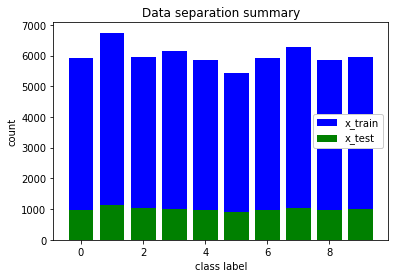

In [7]:
# summary of data shapes:

plt.figure()
plt.title('Data separation summary')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='b')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='g')
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

## Build Model

In [8]:
# Model

input_shape = (target_rows, target_cols, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
______________________________________

## Graph Creation

In [11]:
# add place for input and pred label
x = Input(shape=input_shape)
y_pred = model(x)

# add place for truth label
y_true = Input(shape=(num_classes, ))

In [12]:
# define loss function in terms of y_pred and y_true
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

In [14]:
# EXAMPLE from https://stackoverflow.com/questions/46772685/how-to-accumulate-gradients-in-tensorflow

## Optimizer definition - nothing different from any classical example
opt = tf.train.AdamOptimizer()

## Retrieve all trainable variables you defined in your graph
tvs = tf.trainable_variables()

## Creation of a list of variables with the same shape as the trainable ones
# initialized with 0s
accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in tvs]
zero_ops = [tv.assign(tf.zeros_like(tv)) for tv in accum_vars]

## Calls the compute_gradients function of the optimizer to obtain... the list of gradients
gvs = opt.compute_gradients(loss, tvs)

## Adds to each element from the list you initialized earlier with zeros its gradient (works because accum_vars and gvs are in the same order)
accum_ops = [accum_vars[i].assign_add(gv[0]) for i, gv in enumerate(gvs)]

## Define the training step (part with variable value update)
train_step = opt.apply_gradients([(accum_vars[i], gv[1]) for i, gv in enumerate(gvs)])

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


## Split Training

In [15]:
# TODO

In [ ]:
## The while loop for training
while ...:
    # Run the zero_ops to initialize it
    sess.run(zero_ops)
    # Accumulate the gradients 'n_minibatches' times in accum_vars using accum_ops
    for i in xrange(n_minibatches):
        sess.run(accum_ops, feed_dict=dict(X: Xs[i], y: ys[i]))
    # Run the train_step ops to update the weights based on your accumulated gradients
    sess.run(train_step)

In [ ]:
# Loss
def loss_fn(y_true, y_pred):
    # You can get all the crazy and twisted you 
    # want here no Keras restrictions this time :)
    loss_value = K.sum(K.pow((y_true - y_pred), 2))
    return loss_value

# Optimizer to run the gradients
optimizer = Adam(lr=1e-4)

# Graph creation
# Creating training flow
# Ground truth input, samples or X_t
y_true = Input(shape=[0])

# Prediction
y_pred = model(x)

# Loss 
loss = loss_fn(y_true, y_pred)

# Operation for getting 
# gradients and updating weights
updates_op = optimizer.get_updates(
    params=model.trainable_weights, 
    loss=loss)

# The graph is created, now we need to call it
# this would be similar to tf session.run()
train = K.function(
    inputs=[x, y_true], 
    outputs=[loss], 
    updates=updates_op)

test = K.function(
    inputs=[x, y_true], 
    outputs=[loss])


# Training loop
epochs = 100

for epoch in range(epochs):
    print('Epoch %s:' % epoch)

    # Fancy progress bar
    pbar = tqdm(range(len(samples)))

    # Storing losses for computing mean
    losses_train = []

    # Batch loop: batch size=1
    for idx in pbar:
        sample = samples[idx]
        target = targets[idx]

        # Adding batch dim since batch=1
        sample = np.expand_dims(sample, axis=0)
        target = np.expand_dims(target, axis=0)

        # To tensors, input of 
        # K.function must be tensors
        sample = K.constant(sample)
        target = K.constant(target)

        # Running the train graph
        loss_train = train([sample, target])
        
        # Compute loss mean
        losses_train.append(loss_train[0])
        loss_train_mean = np.mean(losses_train)
        
        # Update progress bar
        pbar.set_description('Train Loss: %.3f' % loss_train_mean)

    # Testing
    losses_test = []
    for idx in range(len(samples_test)):
        sample_test = samples_test[idx]
        target_test = targets_test[idx]

        # Adding batch dim since batch=1
        sample_test = np.expand_dims(sample_test, axis=0)
        target_test = np.expand_dims(target_test, axis=0)

        # To tensors
        sample_test = K.constant(sample_test)
        target_test = K.constant(target_test)
        
        # Evaluation test graph
        loss_test = test([sample_test, target_test])
        
        # Compute test loss mean
        losses_test.append(loss_test[0])
    
    loss_test_mean = np.mean(losses_test)
    print('Test Loss: %.3f' % loss_test_mean)